# WFC3 IR Blob Classification: Data Processing

### The purpose of this notebook is to walk the user through the data processing pipeline for the WFC3 IR Blob Classifier. In this notebook, the user will:

### 1. Process IR images. 

#### The data processing and augmentation pipeline is as follows:
#### - Use vmin/vmax from zscale function to determine clip min/max values for data.
#### - Change border and nan values to median.
#### - Normalize data to N(0, 1), where blobs are positive values, background is near 0, and random noise are negative values.
#### - Grab random 256x256 subframes from a 1024x1024 image. The size of the subframe significantly increases computation efficiency.
#### - Add random noise (N(0, 0.75)), rotation, and flipping to subframes to diversify the dataset.

### 2. Produce training, validation, and test sets of IR blob subframes.
#### With the data processing pipeline, we can generate and save training, validation, and test sets, containinng hundreds to thousands of subframes from 1024x1024 blob images. 
#### We can even superimpose blobs onto non blob subframes to increase blob data set diversity, which increases the chances that the model truly learns what a blob is.

## Introduction
### Data preparation is a crucial step before training a machine learning algorithm, as it helps to prevent things like over-correction and bias. Since we are using the supervised machine learning technique to train our model, it is fed two different types of data: blob images, and non-blob images. The blob images are cutouts that contain one or more blobs, while the non-blob images are cutouts of previously calculated blob difference images that do not contain any blobs. Both types of datasets will be fed into the model for training and validation, and the model will be able to distinguish images that contain blobs, from images that do not. 

### The data processing step contains three key components: 
### 1. Clipping for outliers 
### 2. Scaling
### 3. Diversifying

## Imports
### This notebook also uses functions defined in the complimentary python script, wfc3_ir_blob_class_utils.py. Please read the documentation of the script for further knowledge about it's functionality under Data Processing

In [1]:
import os
from glob import glob

import numpy as np
import torch
from matplotlib import pyplot as plt
from ginga.util.zscale import zscale
from astropy.io import fits

In [2]:
%run wfc3_ir_blob_class_utils.py

## Load and plot preprocessed data

In [3]:
BLOB = 'example_data/example_blob.fits'
NON_BLOB = 'example_data/example_non_blob.fits'
MEDIAN = 'example_data/example_median_stack.fits'

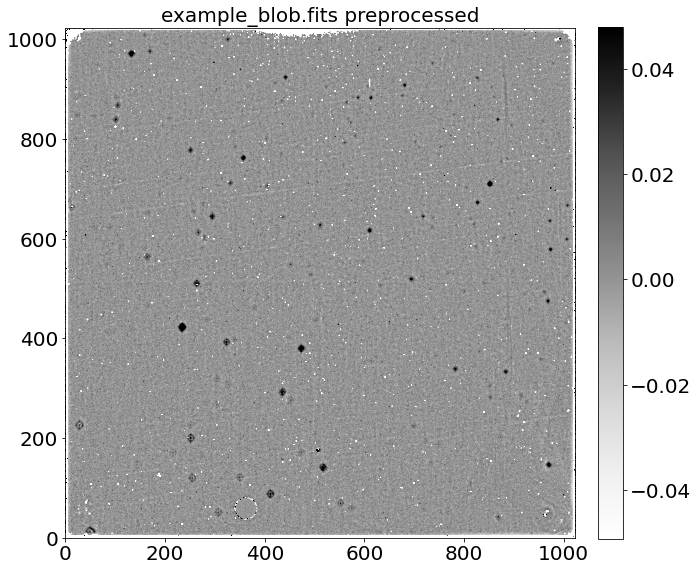

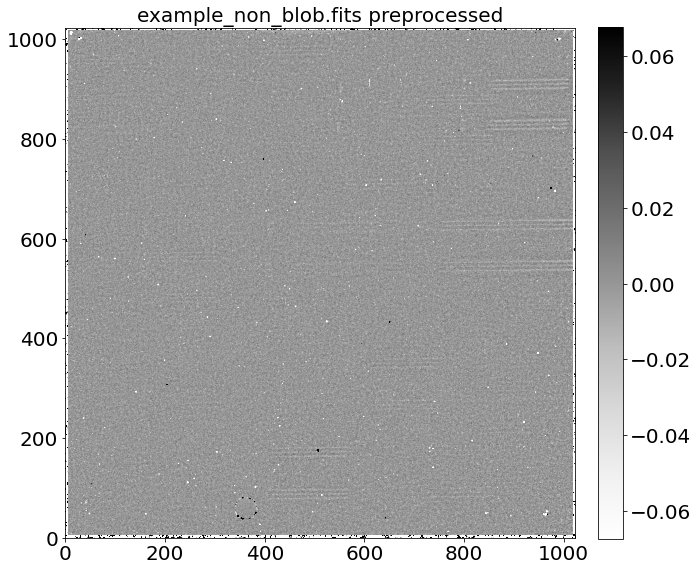

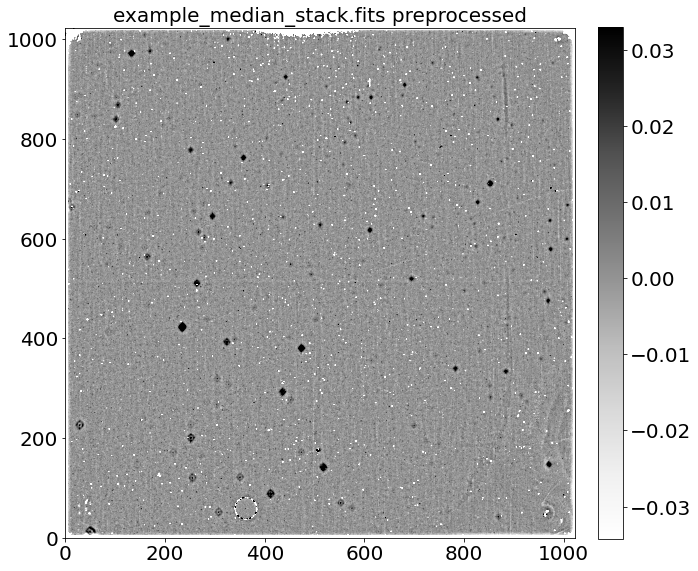

In [4]:
blob_pre = plot_pre_processed(BLOB, show_hist=False, stack=0)
non_blob_pre = plot_pre_processed(NON_BLOB, show_hist=False, stack=0)
median_pre = plot_pre_processed(MEDIAN, show_hist=False, stack=1)

## Clipping data
### The machine learning algorithm cannot take non finite pixel values. They must either be changed to the median or clipped to a min/max value. In addition, normalizing data is a common practice in machine learning to increase computational efficiency. 
<br>
</br>

### The following cell will perform clipping based on a clipping factor which is set to 0.5 by default. Factors of 0.3, 0.5, and 0.6 keep approximately 95%, 99.7%, and 99.994% of the data centered around the median. The lower the factor, the stronger the clipping effect will be. For example, with a clipping factor of 0.5, the minimum and maximum clipping threshold are determined such that 99.7% of the pixels have their original values preserved. The rest of the pixels have their values replaced with the minimum or maximum clipping threshold value, depending on their original values.

In [7]:
clipping_factor = 0.5 
blob_norm = scale_data(blob_pre, factor=clipping_factor)
non_blob_norm = scale_data(non_blob_pre, factor=clipping_factor)
median_norm = scale_data(median_pre, factor=clipping_factor)

Nonfinite values before normalizing have been changed.
Nonfinite values before normalizing have been changed.
Nonfinite values before normalizing have been changed.


## Normalize and plot data
### Once the major outliers are clipped, the next step is to perform z-scale normalization on the image. Z-scale normalization is a common normalization technique used in machine learning, intended to normalize the pixels so that their values are changed to represent the number of standard deviations they are away from the mean. For our case, z-scale normalization can be expressed with the following formula: <br>

$Scaled\ Pixel = \frac{Pixel - Clipped\ Mean\ Pixel}{Clipped\ Standard\ Deviation}$

<br>
</br>

### The blob images used for training have been taken in different epochs over the course of several years, so normalizing these images will prevent any time-dependent structure from compromising the model's learning process. It is basically to ensure that all the images are on the same "playing field". 

Nonfinite values before normalizing have been changed.


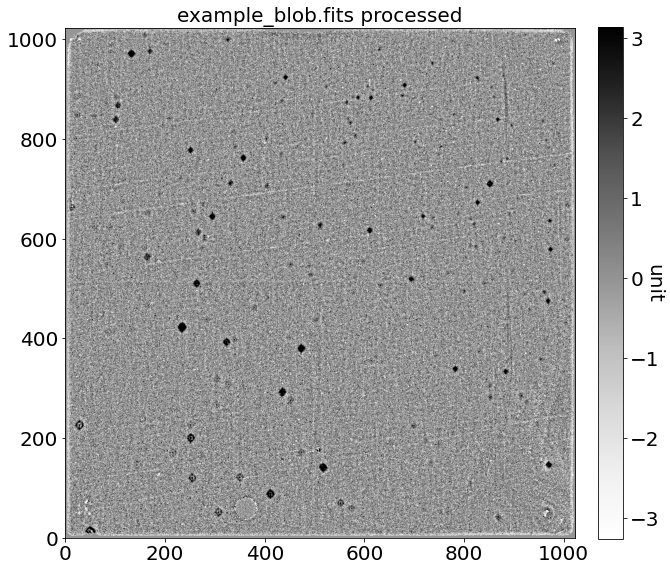

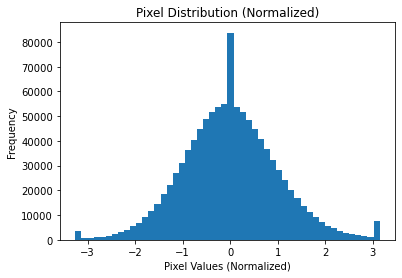

Nonfinite values before normalizing have been changed.


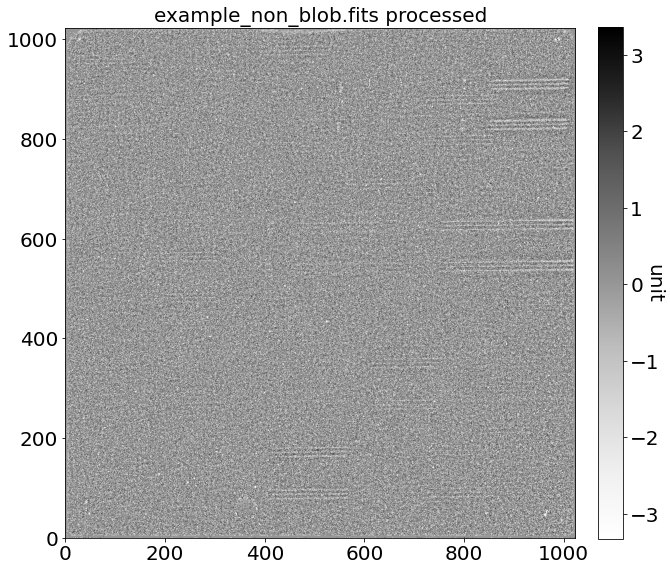

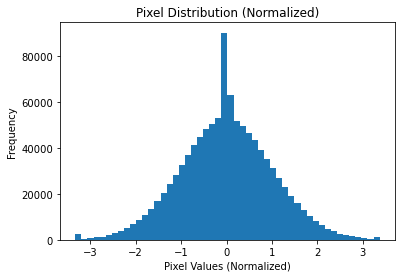

Nonfinite values before normalizing have been changed.


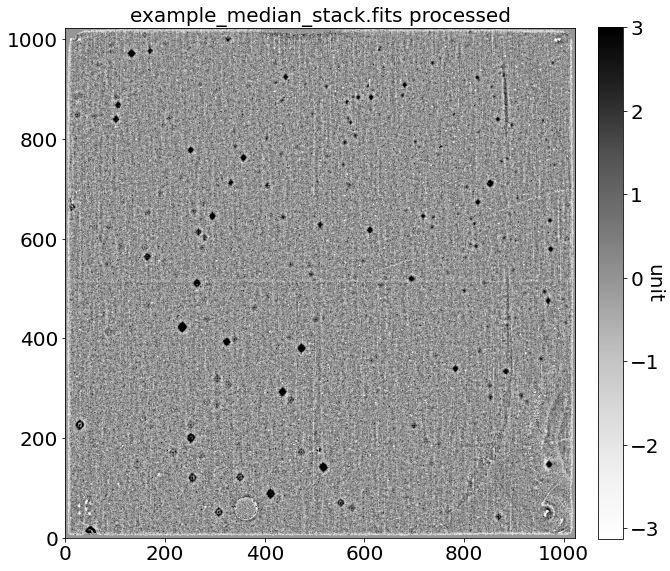

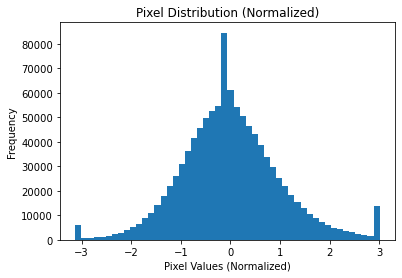

In [8]:
blob_norm = plot_scaled_blobs(BLOB, stack=0, factor=clipping_factor)
non_blob_norm = plot_scaled_blobs(NON_BLOB, stack=0, factor=clipping_factor)
median_norm = plot_scaled_blobs(MEDIAN, stack=1, factor=clipping_factor)

## Cut image into 16 unique subframes and plot
### The end goal of the model is to classify 16 unique subframes to check if any new blobs appear. We'll save these subframes to be used as a final test.

In [ ]:
!mkdir saved_generated_datasets

In [ ]:
blob_full = grab_full_subframes(blob_norm)
non_blob_full = grab_full_subframes(non_blob_norm)
median_full = grab_full_subframes(median_norm)
np.savez_compressed('saved_generated_datasets/final_test.npz', 
                    blob=blob_full, 
                    non_blob=non_blob_full, 
                    median=median_full)

In [ ]:
fig, axs = plt.subplots(4,4,figsize=[10,10])
blob_full = np.array(blob_full).reshape(4,4,256,256)
for i in range(4):
    for j in range (4):
        axs[i, j].set_title('Unique Frame: {}'.format(i * 4 + j))
        axs[i, j].imshow(blob_full[i, j], cmap='Greys')
plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(4,4,figsize=[10,10])
non_blob_full = np.array(non_blob_full).reshape(4,4,256,256)
for i in range(4):
    for j in range (4):
        axs[i, j].set_title('Unique Frame: {}'.format(i * 4 + j))
        axs[i, j].imshow(non_blob_full[i, j], cmap='Greys')
plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(4,4,figsize=[10,10])
median_full = np.array(median_full).reshape(4,4,256,256)
for i in range(4):
    for j in range (4):
        axs[i, j].set_title('Unique Frame: {}'.format(i * 4 + j))
        axs[i, j].imshow(median_full[i, j], cmap='Greys')
plt.tight_layout()

## Building make_dataset()
### These next few blocks show the functionality of the data augmentation functions.

### Grab a random subframe from the image

In [ ]:
blob_random = grab_random_subframe(blob_norm)
non_blob_random_train = grab_random_subframe(non_blob_norm, sets=[True, False])
median_random_val = grab_random_subframe(median_norm, sets=[False, True])

### Flip and plot random subframe

In [ ]:
blob_flip = flip(blob_random)
non_blob_flip = flip(non_blob_random_train)
median_flip = flip(median_random_val)

In [ ]:
random = [blob_random, non_blob_random_train, median_random_val]
flipped = [blob_flip, non_blob_flip, median_flip]
random_flipped_subframes = np.array([random, flipped])

In [ ]:
titles = ['Random Blob Subframe', 'Random Non Blob Subframe', 'Random Median Stack Subframe']

In [ ]:
x, y, _, __ = random_flipped_subframes.shape
fig, axs = plt.subplots(x, y, figsize=[x*10,y*3])
for i in range (x):
    for j in range (y):
        if i == 1:
            titles[j] += ' (Flipped)'
        axs[i, j].set_title(titles[j])
        axs[i, j].imshow(random_flipped_subframes[i, j], cmap='Greys')
plt.tight_layout()

### Superimpose random blobs on non blob subframe

In [ ]:
blob_superimpose = add_blobs(non_blob_random_train)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=[10,20])
axs[0].set_title('Random Non Blob Subframe')
axs[0].imshow(non_blob_random_train, cmap='Greys')
axs[1].set_title('Random Non Blob Subframe with Superimposed Blobs')
axs[1].imshow(blob_superimpose, cmap='Greys')
plt.tight_layout()

## Make dataset from one image

In [ ]:
data_set = make_dataset(MEDIAN, 
                        100, 
                        stack=1, 
                        factor=0.5, 
                        superimpose=False, 
                        sets=[False, False])

## Save example generated datasets using superimpose. 
### CAUTION: In this example, we are creating training, validation, and test sets for bob and non blob data. Each of these six sets have a size of 200 subframes, 256x256 pixels per subframe. Each set is around 50MB of space. Creating substantially larger datasets will use a lot of space (e.g. tens of GB). When creating larger datasets, it's recommended to either:
#### 1. Prepare your local device to store the sets
#### 2. Save sets on a hard drive
#### 3. Save sets on a path with more space (i.e. central storage)
### Storage space is user based so prepare in whichever way is most comfortable.

In [ ]:
# Non blob training set

path = 'saved_generated_datasets/training_non_blob.npz'
save_image_set, save_labels = save_generated_dataset([NON_BLOB], 
                                                     path, 
                                                     blob=False, 
                                                     itertimes=100, 
                                                     stack=0, 
                                                     factor=0.5, 
                                                     plot=False, 
                                                     superimpose=False, 
                                                     sets=[True, False])

In [ ]:
# Blob training set

path = 'saved_generated_datasets/training_blob.npz'
save_image_set, save_labels = save_generated_dataset([NON_BLOB], 
                                                     path, 
                                                     blob=True, 
                                                     itertimes=100, 
                                                     stack=0, 
                                                     factor=0.5, 
                                                     plot=False, 
                                                     superimpose=True, 
                                                     sets=[True, False])

In [ ]:
# Non blob validation set

path = 'saved_generated_datasets/validation_non_blob.npz'
save_image_set, save_labels = save_generated_dataset([NON_BLOB], 
                                                     path, 
                                                     blob=False, 
                                                     itertimes=100, 
                                                     stack=0, 
                                                     factor=0.5, 
                                                     plot=False, 
                                                     superimpose=False, 
                                                     sets=[False, True])

In [ ]:
# Blob validation set

path = 'saved_generated_datasets/validation_blob.npz'
save_image_set, save_labels = save_generated_dataset([NON_BLOB], 
                                                     path, 
                                                     blob=True, 
                                                     itertimes=100, 
                                                     stack=0, 
                                                     factor=0.5, 
                                                     plot=False, 
                                                     superimpose=True, 
                                                     sets=[False, True])

In [ ]:
# Non blob test set

path = 'saved_generated_datasets/test_non_blob.npz'
save_image_set, save_labels = save_generated_dataset([NON_BLOB], 
                                                     path, 
                                                     blob=False, 
                                                     itertimes=100, 
                                                     stack=0, 
                                                     factor=0.5, 
                                                     plot=False, 
                                                     superimpose=False, 
                                                     sets=[False, False])

In [ ]:
# Blob test set

path = 'saved_generated_datasets/test_blob.npz'
save_image_set, save_labels = save_generated_dataset([NON_BLOB], 
                                                     path, 
                                                     blob=True, 
                                                     itertimes=100, 
                                                     stack=0, 
                                                     factor=0.5, 
                                                     plot=False, 
                                                     superimpose=True, 
                                                     sets=[False, False])

## Complete! Move onto Modeling Notebook